In [114]:
import os
import time
import cv2
import numpy
import numpy as np
import glob
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from tensorflow.python.keras.utils.version_utils import callbacks
from google.colab.patches import cv2_imshow

width = 128
height = 128
dim = (width, height)
depth = 3

In [ ]:
def read_images_and_preprocessing():
    # create lists to save images and labels (the folder which the image came from)
    cv_img = []
    cv_img_label = []
    # add "yes" images to list
    for img in glob.glob("/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/yes/*.jpg"):
        n = cv2.imread(img)
        # convert to gray scale
        n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        # normalize data to range(0,1).
        # In future - the normalization makes convergence faster while training the network.
        n = cv2.normalize(n, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # resize image - change dimensions -> from RGB(3 channels) to gray(1 channel)
        resized = cv2.resize(n, dim, interpolation=cv2.INTER_AREA)
        # add image after changes to image list
        cv_img.append(resized)
        # add label 1 (=is brain tumor)
        cv_img_label.append(1)
    # add "No" images to list
    for img in glob.glob("/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/no/*.jpg"):
        n = cv2.imread(img)
        # convert to gray scale
        n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        # normalize data to range(0,1).
        # In future - the normalization makes convergence faster while training the network.
        n = cv2.normalize(n, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # resize image - change dimensions -> from RGB(3 channels) to gray(1 channel)
        resized = cv2.resize(n, dim, interpolation=cv2.INTER_AREA)
        cv_img.append(resized)
        cv_img_label.append(0)
    # create tuple (images,labels)
    tup_cv_image = (cv_img, cv_img_label)
    return tup_cv_image


In [ ]:
def augmentation(tup_cv_image):
    # ----------------------flip horizontal----------------------
    # create list to save images after perform flip horizontal
    flip_horiz_images = []
    flip_horiz_images_label = []
    # iterate each image in original tuple and make Flipping
    for img, label in zip(tup_cv_image[0],tup_cv_image[1]):
        img = np.array(img)
        flipped_img = np.fliplr(img)
        flip_horiz_images.append(flipped_img)
        flip_horiz_images_label.append(label)
    # create tuple (images,labels)
    tup_flip_horiz = (flip_horiz_images, flip_horiz_images_label)
    # ----------------------add some noise----------------------
    noise_images = []
    noise_images_label =[]
    for img, label in zip(tup_cv_image[0],tup_cv_image[1]):
        noise = np.random.uniform(low=0, high=0.5, size=(128, 128))
        new_img = np.zeros((128, 128))
        for i in range(width):
            for j in range(height):
                if np.any(img[i][j] != 1):
                    # adding noise
                    new_img[i][j] = img[i][j] + noise[i][j]
                    # range of pixel is between [0,1] , can't over 1 after adding noise.
                    if new_img[i][j] > 1:
                        new_img[i][j] = 1
        noise_images.append(new_img)
        noise_images_label.append(label)
    # create tuple (images,labels)
    tup_noise = (noise_images, noise_images_label)
    # ----------------------flip vertical----------------------
    flip_ver_images = []
    flip_ver_images_label = []
    for img, label in zip(tup_cv_image[0],tup_cv_image[1]):
        flipped_ver_image = cv2.flip(img, 0)
        flip_ver_images.append(flipped_ver_image)
        flip_ver_images_label.append(label)
    # create tuple (images,labels)
    tup_flip_ver = (flip_ver_images,flip_ver_images_label)
    # ----------------------concatenate all lists - create new dataset ----------------------
    new_data_set = tup_cv_image[0] + tup_flip_horiz[0] + tup_noise[0] + tup_flip_ver[0]
    new_data_set_label = tup_cv_image[1] + tup_flip_horiz[1] + tup_noise[1] + tup_flip_ver[1]
    tup_new_dataset = (new_data_set, new_data_set_label)
    return tup_new_dataset

In [ ]:
def build_cnn_model(tup_new_dataset):
    print(tup_new_dataset[0][0])
    # split new dataset -> 80% train, 20% test
    train, test, train_labels, test_labels = train_test_split(tup_new_dataset[0], tup_new_dataset[1],train_size=0.8)
    test_before_changes = np.copy(test)
    # convert to float because model.fit can't get np
    train = np.float32(train)
    train_labels = np.float32(train_labels)
    test = np.float32(test)
    test_labels = np.float32(test_labels)
    # Reshape data for model.fit -> from (height, width, channel) change to (len, height, width, channel)
    train = train.reshape(len(train), height, width, 1)
    test = test.reshape(len(test), height, width, 1)
    # build CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,1)))
    model.add(layers.MaxPool2D())

    model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(layers.MaxPool2D())

    model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(2, activation="softmax"))
    model.summary()
    # compile and train the model
    model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    # early stopping is using in training and comes training to halt when there is an increment observed in loss values.
    # earlystopping = callbacks.EarlyStopping(monitor="val_loss",mode="min", patience=5, restore_best_weights=True)
    # history = model.fit(train, train_labels, epochs=25, validation_data=(test, test_labels),callbacks=[earlystopping])
    history = model.fit(train, train_labels, epochs=9, validation_data=(test, test_labels))
    plt.figure()  # create a plot figure
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    test_loss, test_acc = model.evaluate(test, test_labels, verbose=2)
    plt.show()
    print("Accuracy  of the model is: " + str(test_acc))
    # save all images who get "yes" classification
    # for each image in test we get two value , probability to be in class 0 and probability to be in class 1
    # the sum of each row is 1
    probas = model.predict(test)
    # for each image return the index 0 or 1 which their probability is higher
    classes = np.argmax(probas, axis=1)
    index_img_in_test_class1 = [i for i, n in enumerate(classes) if n == 1]
    images_test_class1 = test_before_changes[index_img_in_test_class1]

    # ROC curve
    y_score1 = model.predict_proba(test)[:, 1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_labels, y_score1)
    plt.subplots(1, figsize=(10,10))
    plt.title('Roc')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # confusion matrix
    matrix = confusion_matrix(test_labels, classes, labels=[1, 0])
    print('Confusion matrix : \n', matrix)
    return images_test_class1

In [139]:
# first segmentation
def threshold_seg(img):
    ret, thresh3 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
    cv2_imshow(thresh3)
    cv2.waitKey(0)
    return thresh3/255


# second segmentation
def edge_based_seg(img):
    edges = canny(img / 1.)
    fill_img = ndi.binary_fill_holes(edges)
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(numpy.invert(fill_img), cmap=plt.cm.gray, interpolation='nearest')
    ax.axis('off')
    ax.set_title('Filling the holes')
    plt.show()
    return fill_img


# three segmentation
def region_based_seg(img):
    elevation_map = sobel(img)
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
    ax.axis('off')
    ax.set_title('elevation_map')
    plt.show()
    return elevation_map

# This function is apply 3 types of segmentation and calculated Dice score for each technique.
def dice():
    target1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/target_7.png',cv2.IMREAD_GRAYSCALE) / 255
    img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/7.jpg', cv2.IMREAD_GRAYSCALE)
    target2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/target_145.png', cv2.IMREAD_GRAYSCALE) / 255
    img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/145.jpg', cv2.IMREAD_GRAYSCALE)
    target3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/target_146.png', cv2.IMREAD_GRAYSCALE) / 255
    img3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/146.jpg', cv2.IMREAD_GRAYSCALE)
    target4 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/target_149.png', cv2.IMREAD_GRAYSCALE) / 255
    img4 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/149.jpg', cv2.IMREAD_GRAYSCALE)
    target5 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/target_150.png', cv2.IMREAD_GRAYSCALE) / 255
    img5 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/150.jpg', cv2.IMREAD_GRAYSCALE)

    img1_threshold = threshold_seg(img1)
    img1_edge = edge_based_seg(img1)
    img1_region = region_based_seg(img1)

    img2_threshold = threshold_seg(img2)
    img2_edge = edge_based_seg(img2)
    img2_region = region_based_seg(img2)

    img3_threshold = threshold_seg(img3)
    img3_edge = edge_based_seg(img3)
    img3_region = region_based_seg(img3)

    img4_threshold = threshold_seg(img4)
    img4_edge = edge_based_seg(img4)
    img4_region = region_based_seg(img4)

    img5_threshold = threshold_seg(img5)
    img5_edge = edge_based_seg(img5)
    img5_region = region_based_seg(img5)


    dice1_threshold = 2 * (np.sum(np.multiply(img1_threshold, target1))) / (np.sum(img1_threshold) + np.sum(target1))
    dice1_edge = 2 * (np.sum(np.multiply(img1_edge, target1))) / (np.sum(img1_edge) + np.sum(target1))
    dice1_region = 2 * (np.sum(np.multiply(img1_region, target1))) / (np.sum(img1_region) + np.sum(target1))

    dice2_threshold = 2 * (np.sum(np.multiply(img2_threshold, target2))) / (np.sum(img2_threshold) + np.sum(target2))
    dice2_edge = 2 * (np.sum(np.multiply(img2_edge, target2))) / (np.sum(img2_edge) + np.sum(target2))
    dice2_region = 2 * (np.sum(np.multiply(img2_region, target2))) / (np.sum(img2_region) + np.sum(target2))

    dice3_threshold = 2 * (np.sum(np.multiply(img3_threshold, target3))) / (np.sum(img3_threshold) + np.sum(target3))
    dice3_edge = 2 * (np.sum(np.multiply(img3_edge, target3))) / (np.sum(img3_edge) + np.sum(target3))
    dice3_region = 2 * (np.sum(np.multiply(img3_region, target3))) / (np.sum(img3_region) + np.sum(target3))

    dice4_threshold = 2 * (np.sum(np.multiply(img4_threshold, target4))) / (np.sum(img4_threshold) + np.sum(target4))
    dice4_edge = 2 * (np.sum(np.multiply(img4_edge, target4))) / (np.sum(img4_edge) + np.sum(target4))
    dice4_region = 2 * (np.sum(np.multiply(img4_region, target4))) / (np.sum(img4_region) + np.sum(target4))

    dice5_threshold = 2 * (np.sum(np.multiply(img5_threshold, target5))) / (np.sum(img5_threshold) + np.sum(target5))
    dice5_edge = 2 * (np.sum(np.multiply(img5_edge, target5))) / (np.sum(img5_edge) + np.sum(target5))
    dice5_region = 2 * (np.sum(np.multiply(img5_region, target5))) / (np.sum(img5_region) + np.sum(target5))

    seg_type = ['img/type', 'Threshold', 'Edge based', 'Region based']
    img_num = ['image 1','image 2','image 3','image 4','image 5']
    dice_arr1 = [dice1_threshold,dice1_edge,dice1_region]
    dice_arr2 = [dice2_threshold, dice2_edge, dice2_region]
    dice_arr3 = [dice3_threshold, dice3_edge, dice3_region]
    dice_arr4 = [dice4_threshold, dice4_edge, dice4_region]
    dice_arr5 = [dice5_threshold, dice5_edge, dice5_region]

    print('img 1:threshold,edge,region')
    print(dice_arr1)
    print('img 2:threshold,edge,region')
    print(dice_arr2)
    print('img 3:threshold,edge,region')
    print(dice_arr3)
    print('img 4:threshold,edge,region')
    print(dice_arr4)
    print('img 5:threshold,edge,region')
    print(dice_arr5)


[[0.99413943 0.93538177 0.9085907  ... 0.9073416  0.9216848  0.9747977 ]
 [0.9246144  0.42582607 0.19527782 ... 0.20573655 0.42387068 0.94768023]
 [0.9319617  0.3147798  0.06497364 ... 0.04990435 0.32170945 0.9224454 ]
 ...
 [0.9319618  0.3147798  0.06497364 ... 0.03996037 0.3195602  0.9252136 ]
 [0.92461437 0.42582604 0.19527781 ... 0.19328587 0.41994792 0.9512889 ]
 [0.99413943 0.93538177 0.9085907  ... 0.90259427 0.91853863 0.98243535]]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_po

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


18/18 [==============================] - 10s 551ms/step - loss: 0.7243 - accuracy: 0.6124 - val_loss: 0.6406 - val_accuracy: 0.6642
Epoch 2/9
18/18 [==============================] - 10s 540ms/step - loss: 0.5476 - accuracy: 0.7221 - val_loss: 0.5780 - val_accuracy: 0.7153
Epoch 3/9
18/18 [==============================] - 10s 542ms/step - loss: 0.5142 - accuracy: 0.7367 - val_loss: 0.5596 - val_accuracy: 0.7372
Epoch 4/9
18/18 [==============================] - 10s 549ms/step - loss: 0.4611 - accuracy: 0.7751 - val_loss: 0.5861 - val_accuracy: 0.7299
Epoch 5/9
18/18 [==============================] - 10s 547ms/step - loss: 0.4237 - accuracy: 0.7861 - val_loss: 0.5121 - val_accuracy: 0.7883
Epoch 6/9
18/18 [==============================] - 10s 551ms/step - loss: 0.3497 - accuracy: 0.8355 - val_loss: 0.4504 - val_accuracy: 0.8175
Epoch 7/9
18/18 [==============================] - 10s 556ms/step - loss: 0.2861 - accuracy: 0.8739 - val_loss: 0.4417 - val_accuracy: 0.8175
Epoch 8/9
18/18 

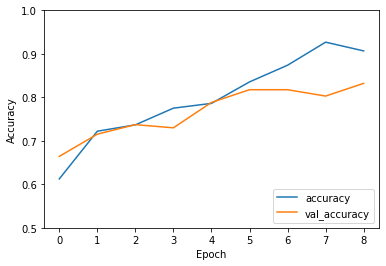

Accuracy  of the model is: 0.8321167826652527


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


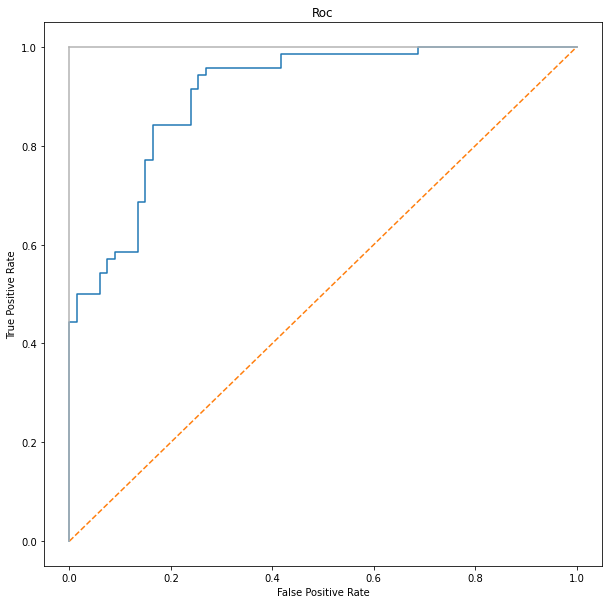

Confusion matrix : 
 [[64  6]
 [17 50]]


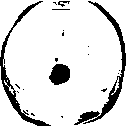

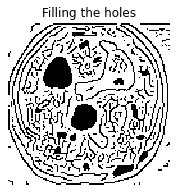

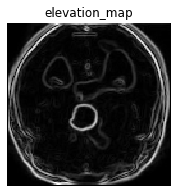

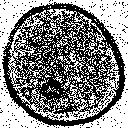

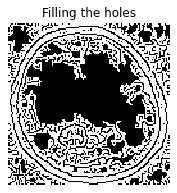

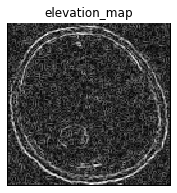

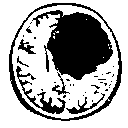

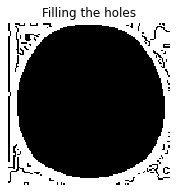

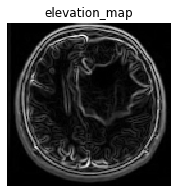

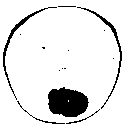

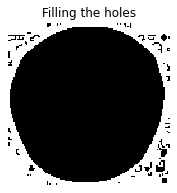

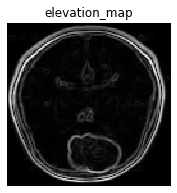

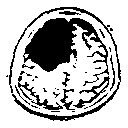

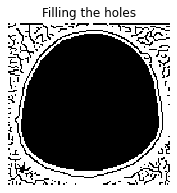

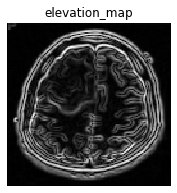

img 1:threshold,edge,region
[0.9924454103280554, 0.37659033078880405, 0.07959458750871606]
img 2:threshold,edge,region
[0.9506630703528883, 0.48730558096980786, 0.20209441421145435]
img 3:threshold,edge,region
[0.9748152082503431, 0.5953360768175583, 0.11536741947217287]
img 4:threshold,edge,region
[0.9967589466576637, 0.7810430771519976, 0.08740796231644517]
img 5:threshold,edge,region
[0.985533232813073, 0.6438445205182649, 0.13494021741438877]


In [141]:
if __name__ == "__main__":
    tup_images_and_labels = read_images_and_preprocessing()
    tup_new_images_and_labels = augmentation(tup_images_and_labels)
    images_test_class1 = build_cnn_model(tup_new_images_and_labels)
    dice()
